In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os
from glob import glob
import sys

import util_tr_new as tr
from scipy import interpolate  # , signal
from scipy.signal import savgol_filter

datadir = Path("/Users/uedataiga/Desktop/grad-research/data_analysis/Data/PPMS/240115_#1-1396(2-1)_100um")
sample = "1396"
if not os.path.exists(datadir / sample):
    os.mkdir(datadir / sample)
savedir = datadir / sample

# RT

header: ['Time (min)', 'Temperature (K)', 'Field (Oe)', 'Position (deg)', 'Lock-in1(X)', 'Lock-in1(Y)', 'Lock-in2(X)', 'Lock-in2(Y)', 'Current(X)', 'Current(Y)']
current=  0.00025


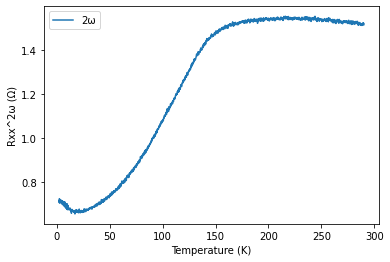

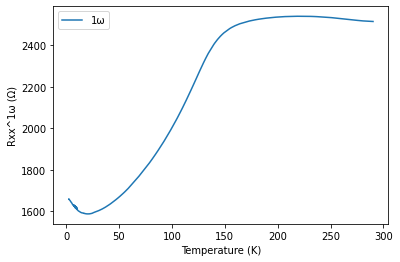

RT.csv saved


In [2]:
# RT
df_dict = {}
# for filename in sorted(glob(str(datadir / "3_14T_sweep_*e-*A.txt"))):
filename = str(datadir / "1_RT.txt")
key = Path(filename).stem
current_float = 250e-6

with open(filename, "r") as f:
    df = []
    i = 0
    while True:
        line = f.readline().strip()
        if not line:
            break
        elif i == 0:
            header = line.split("\t")
            print(f"header: {header}")
        else:
            df.append([float(x) for x in line.split("\t")])
        i += 1
df = pd.DataFrame(df, columns=header)
# df_dict[Path(filename).stem] = df
df = df[["Temperature (K)", "Field (Oe)", "Lock-in1(X)", "Lock-in1(Y)", "Lock-in2(X)", "Lock-in2(Y)"]]
df.to_csv(savedir / ("raw_RT.csv"), index=False)

B_raw = df["Field (Oe)"].values * 1e-4  # Oe -> T
# fixed_temp = df["Temperature (K)"].mean()
temp = df["Temperature (K)"].values
V2omega_raw = df["Lock-in2(Y)"].values
V1omega_raw = -df["Lock-in1(X)"].values  # 位相180°回転に注意

print("current= ", current_float)
Rxx2omega = V2omega_raw / current_float
Rxx1omega = V1omega_raw / current_float
current = np.full_like(temp, current_float)
plt.plot(temp, Rxx2omega, label="2ω")
plt.xlabel("Temperature (K)")
plt.ylabel("Rxx^2ω (Ω)")
plt.legend()
plt.show()
plt.plot(temp, Rxx1omega, label="1ω")
plt.xlabel("Temperature (K)")
plt.ylabel("Rxx^1ω (Ω)")
plt.legend()
plt.show()

new_df = pd.DataFrame({"temp": temp, "current": current, "B": B_raw, "V2omega": V2omega_raw, "V1omega": V1omega_raw, "Rxx2omega": Rxx2omega, "Rxx1omega": Rxx1omega})
new_df.to_csv(savedir / "RT.csv", index=False)
print("RT" + ".csv saved")

1_2T_sweep_250uA
------------------1_2T_sweep_250uA------------------


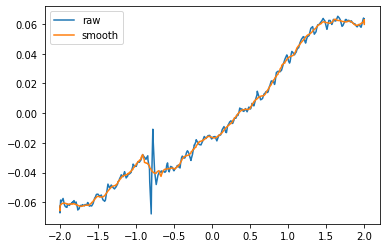

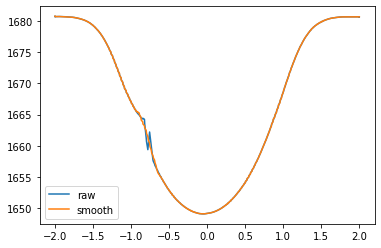

0 1.9999200000000001
R0 =  1680.74550642607 , B =  -2.00008
gamma =  1.6475476987739084e-13


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered 

In [3]:
thickness = 20e-9  # m = 20 nm
width = 100e-6  # m = 20 um
e = 1.602e-19  # C
current_float = 250e-6  # float(key[-5:-1])

# Rxx2omegaの最大の値を計算するためのBの位置
B_Rxx2omega, thresh_Rxx2omega = 2, 0.1
# gammaを計算するためのBの位置
B_gamma, thresh_gamma = 1, 0.1

# temp_dep
df_dict = {}
for filename in sorted(glob(str(datadir / "1_2T_sweep_250uA.txt"))):
    print(Path(filename).stem)
    with open(filename, "r") as f:
        df = []
        i = 0
        while True:
            line = f.readline().strip()
            if not line:
                break
            elif i == 0:
                header = line.split("\t")
            else:
                df.append([float(x) for x in line.split("\t")])
            i += 1
    df = pd.DataFrame(df, columns=header)
    df_dict[Path(filename).stem] = df


# Lock-in2(Y)のみのデータを抽出
# それをI^2で割った値を新たなカラムに追加
# 反対称化
# csv保存
Rxx_lowB_means, Rxx_lowB_stds, currents, gammas, temps, R0s = [], [], [], [], [], []
for key in df_dict.keys():
    print(f"------------------{key}------------------")
    df = df_dict[key]
    df = df[["Temperature (K)", "Field (Oe)", "Lock-in1(X)", "Lock-in1(Y)", "Lock-in2(X)", "Lock-in2(Y)"]]
    df.to_csv(savedir / ("raw_" + key + ".csv"), index=False)

    B_raw = df["Field (Oe)"].values * 1e-4  # Oe -> T
    fixed_temp = df["Temperature (K)"].mean()
    temps.append(fixed_temp)

    V2omega_raw = df["Lock-in2(Y)"].values
    # V1omega_raw = df["Lock-in1(Y)"].values
    V1omega_raw = -df["Lock-in1(X)"].values  # 位相180°回転に注意
    B_ref_u, _, V2omega_u, B_ref_d, _, V2omega_d = tr.symmetrize(*tr.split_up_down_scans(B_raw, V2omega_raw))
    B_ref_u, V1omega_u, _, B_ref_d, V1omega_d, _ = tr.symmetrize(*tr.split_up_down_scans(B_raw, V1omega_raw))
    # (x_ref_u, y_sym_u, y_asym_u, x_ref_d, y_sym_d, y_asym_d)

    # V2omega_d_int = interpolate.interp1d(B_ref_d, V2omega_d)
    # V2omega_u_int = interpolate.interp1d(B_ref_u, V2omega_u)
    temp = np.full_like(B_ref_u, fixed_temp)

    Rxx2omega_u = V2omega_u / current_float
    Rxx2omega_d = V2omega_d / current_float
    Rxx1omega_u = V1omega_u / current_float
    Rxx1omega_d = V1omega_d / current_float
    Rxx2omega_d_smooth = savgol_filter(Rxx2omega_d, 21, 3)
    Rxx2omega_u_smooth = savgol_filter(Rxx2omega_u, 21, 3)
    Rxx1omega_d_smooth = savgol_filter(Rxx1omega_d, 21, 3)
    Rxx1omega_u_smooth = savgol_filter(Rxx1omega_u, 21, 3)
    plt.plot(B_ref_d, Rxx2omega_d, label="raw")
    plt.plot(B_ref_d, Rxx2omega_d_smooth, label="smooth")
    plt.legend()
    plt.show()
    plt.plot(B_ref_d, Rxx1omega_u, label="raw")
    plt.plot(B_ref_d, Rxx1omega_u_smooth, label="smooth")
    plt.legend()
    plt.show()
    current = np.full_like(B_ref_u, current_float)

    # Rxx2omega_dの3T前後の20点の平均，標準偏差を計算
    idx_lowB = np.where(np.abs(np.array(B_ref_d) - B_Rxx2omega) < thresh_Rxx2omega)[0][0]
    print(idx_lowB, B_ref_d[idx_lowB])
    # Rxx_3T_mean = np.mean(Rxx2omega_d_smooth[idx_3T - 10 : idx_3T + 10])
    # Rxx_3T_std = np.std(Rxx2omega_d_smooth[idx_3T - 10 : idx_3T + 10])
    Rxx_lowB_mean = np.mean(Rxx2omega_d_smooth[idx_lowB - 10 : idx_lowB + 10])
    Rxx_lowB_std = np.std(Rxx2omega_d_smooth[idx_lowB - 10 : idx_lowB + 10])
    Rxx_lowB_means.append(Rxx_lowB_mean)
    Rxx_lowB_stds.append(Rxx_lowB_std)
    currents.append(current_float)

    idx_lowB_p = np.where(np.abs(np.array(B_ref_d) - B_gamma) < thresh_gamma)[0][0]
    idx_lowB_n = np.where(np.abs(np.array(B_ref_d) + B_gamma) < thresh_gamma)[0][0]
    DeltaR = (Rxx2omega_d_smooth[idx_lowB_p] - Rxx2omega_d_smooth[idx_lowB_n])
    DeltaB = (B_ref_d[idx_lowB_p] - B_ref_d[idx_lowB_n])
    # print("DeltaR = ", DeltaR)
    # print("B: ", B_ref_d[idx_lowB_p], B_ref_d[idx_lowB_n])
    # print("Rxx2omega: ", Rxx2omega_d_smooth[idx_lowB_p], Rxx2omega_d_smooth[idx_lowB_n])
    current_density = current_float / (width * thickness)  # A/m^2
    # print("current_density = ", current_density)
    # R0 = 0.041106 / current_float  # Ω
    # Rxx1omegaの最大値をR0とする
    R0 = Rxx1omega_d_smooth[np.argmax(Rxx1omega_d_smooth)]
    print("R0 = ", R0, ", B = ", B_ref_d[np.argmax(Rxx1omega_d_smooth)])

    gamma = (DeltaR/DeltaB) / (current_density * R0)
    print("gamma = ", gamma)
    gammas.append(gamma)
    R0s.append(R0)

    Rxx2omega_d_over_R0_B = Rxx2omega_d_smooth / (R0 * current_density)
    Rxx2omega_u_over_R0_B = Rxx2omega_u_smooth / (R0 * current_density)
    new_df = pd.DataFrame({"temp": temp, "current": current, "B_ref_d": B_ref_d, "B_ref_u": B_ref_u, "V2omega_u": V2omega_u, "V2omega_d": V2omega_d, "V1omega_d": V1omega_d, "V1omega_u": V1omega_u, "Rxx2omega_u": Rxx2omega_u_smooth, "Rxx2omega_d": Rxx2omega_d_smooth, "Rxx1omega_u": Rxx1omega_u_smooth, "Rxx1omega_d": Rxx1omega_d_smooth, "Rxx2omega_d_over_R0_B": Rxx2omega_d_over_R0_B, "Rxx2omega_u_over_R0_B": Rxx2omega_u_over_R0_B})

# temp dep

1_9T_sweep_250uA_100K
1_9T_sweep_250uA_10K
1_9T_sweep_250uA_14K
1_9T_sweep_250uA_150K
1_9T_sweep_250uA_20K
1_9T_sweep_250uA_25K
1_9T_sweep_250uA_2K
1_9T_sweep_250uA_30K
1_9T_sweep_250uA_40K
1_9T_sweep_250uA_50K
------------------1_9T_sweep_250uA_100K------------------


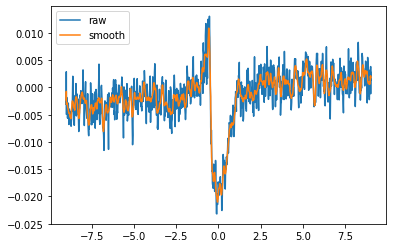

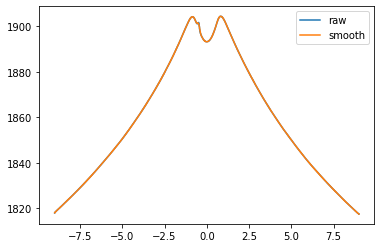

(array([566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578,
       579, 580, 581]),)
566 2.08372
R0 =  1904.4335849967504 , B =  0.8125020000000001
gamma =  -7.75108786414861e-15
1_9T_sweep_250uA_100K.csv saved
------------------1_9T_sweep_250uA_10K------------------


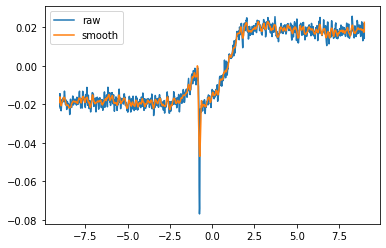

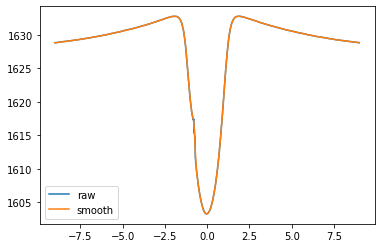

(array([621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633,
       634, 635, 636, 637, 638]),)
621 2.0905
R0 =  1632.8135961733758 , B =  1.8809099999999999
gamma =  2.297831134358621e-14
1_9T_sweep_250uA_10K.csv saved
------------------1_9T_sweep_250uA_14K------------------


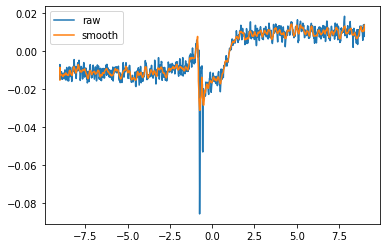

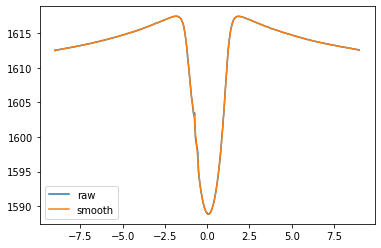

(array([589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601,
       602, 603, 604]),)
589 2.08805
R0 =  1617.431581361112 , B =  -1.83183
gamma =  -1.0277009371752435e-15
1_9T_sweep_250uA_14K.csv saved
------------------1_9T_sweep_250uA_150K------------------


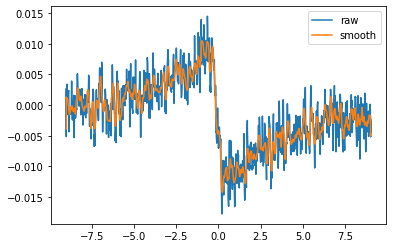

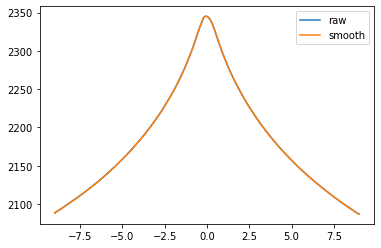

(array([566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578,
       579, 580, 581, 582]),)
566 2.0994
R0 =  2345.262876851622 , B =  -0.0546707
gamma =  -3.216856168158592e-14
1_9T_sweep_250uA_150K.csv saved
------------------1_9T_sweep_250uA_20K------------------


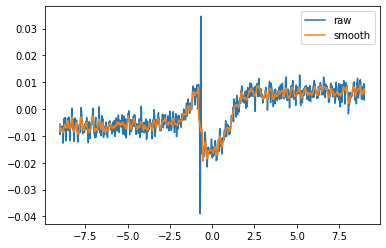

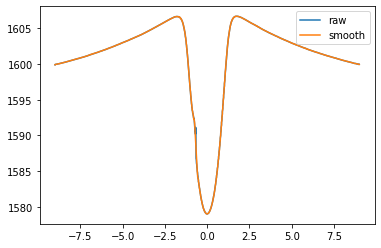

(array([572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584,
       585, 586, 587]),)
572 2.09017
R0 =  1606.6969954691585 , B =  1.72711
gamma =  -3.0391551686443064e-14
1_9T_sweep_250uA_20K.csv saved
------------------1_9T_sweep_250uA_25K------------------


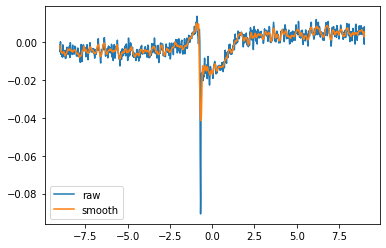

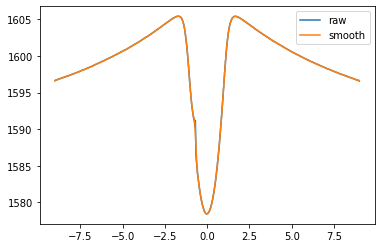

(array([578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590,
       591, 592, 593]),)
578 2.0984700000000003
R0 =  1605.4272930027157 , B =  -1.7027599999999998
gamma =  -3.579025739531331e-14
1_9T_sweep_250uA_25K.csv saved
------------------1_9T_sweep_250uA_2K------------------


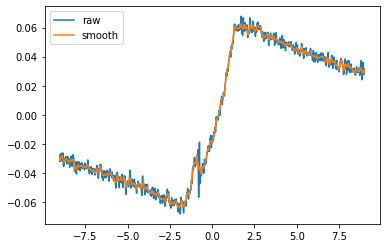

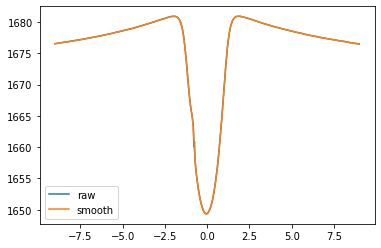

(array([616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628,
       629, 630, 631, 632, 633]),)
616 2.09525
R0 =  1680.9101085502439 , B =  1.8956700000000002
gamma =  1.684933010437837e-13
1_9T_sweep_250uA_2K.csv saved
------------------1_9T_sweep_250uA_30K------------------


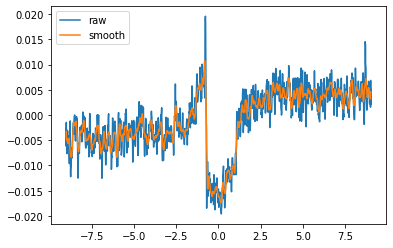

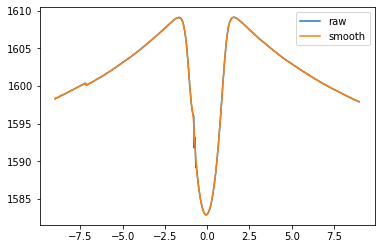

(array([557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569,
       570, 571, 572]),)
557 2.0875500000000002
R0 =  1609.139978170996 , B =  1.56719
gamma =  -2.5475855041692527e-14
1_9T_sweep_250uA_30K.csv saved
------------------1_9T_sweep_250uA_40K------------------


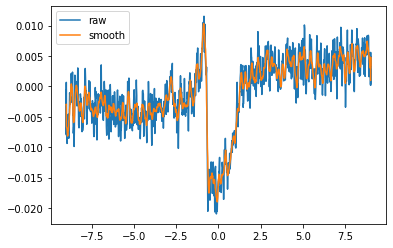

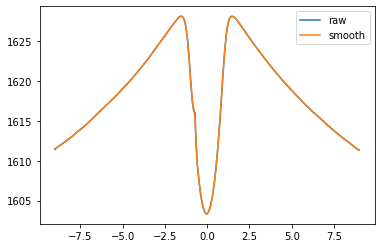

(array([563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575,
       576, 577, 578]),)
563 2.0876200000000003
R0 =  1628.089787759703 , B =  -1.53408
gamma =  -3.606794701446995e-14
1_9T_sweep_250uA_40K.csv saved
------------------1_9T_sweep_250uA_50K------------------


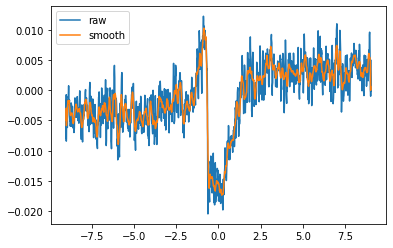

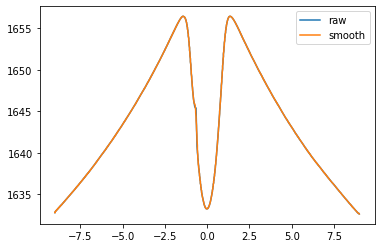

(array([565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577,
       578, 579, 580]),)
565 2.0820900000000004
R0 =  1656.4618530528387 , B =  1.3626600000000002
gamma =  -2.6771290915695893e-14
1_9T_sweep_250uA_50K.csv saved
Rxx_2T_250uA_T_dep.csv saved
[99.9998248826291, 10.000085766646306, 14.000176943174395, 150.00003204272363, 20.000182689747007, 25.00021638269987, 2.4500297796817625, 30.00068061016949, 40.00055933694181, 50.000184882943145]


In [4]:
thickness = 20e-9  # m = 20 nm
width = 100e-6  # m = 20 um
e = 1.602e-19  # C
current_float = 250e-6  # float(key[-5:-1])

# Rxx2omegaの最大の値を計算するためのBの位置
B_Rxx2omega, thresh_Rxx2omega = 2, 0.1
# gammaを計算するためのBの位置
B_gamma, thresh_gamma = 1, 0.1
df_gamma_name = f"gamma_{B_gamma}T_250uA_T_dep.csv"
summary_name = f"Rxx_{B_Rxx2omega}T_250uA_T_dep.csv"


# temp_dep
df_dict = {}
for filename in sorted(glob(str(datadir / "1_9T_sweep_250uA_*K.txt"))):
    print(Path(filename).stem)
    with open(filename, "r") as f:
        df = []
        i = 0
        while True:
            line = f.readline().strip()
            if not line:
                break
            elif i == 0:
                header = line.split("\t")
            else:
                df.append([float(x) for x in line.split("\t")])
            i += 1
    df = pd.DataFrame(df, columns=header)
    df_dict[Path(filename).stem] = df


# Lock-in2(Y)のみのデータを抽出
# それをI^2で割った値を新たなカラムに追加
# 反対称化
# csv保存
Rxx_lowB_means, Rxx_lowB_stds, currents, gammas, temps, R0s = [], [], [], [], [], []
for key in df_dict.keys():
    print(f"------------------{key}------------------")
    df = df_dict[key]
    df = df[["Temperature (K)", "Field (Oe)", "Lock-in1(X)", "Lock-in1(Y)", "Lock-in2(X)", "Lock-in2(Y)"]]
    df.to_csv(savedir / ("raw_" + key + ".csv"), index=False)

    B_raw = df["Field (Oe)"].values * 1e-4  # Oe -> T
    fixed_temp = df["Temperature (K)"].mean()
    temps.append(fixed_temp)

    V2omega_raw = df["Lock-in2(Y)"].values
    # V1omega_raw = df["Lock-in1(Y)"].values
    V1omega_raw = -df["Lock-in1(X)"].values  # 位相180°回転に注意
    B_ref_u, _, V2omega_u, B_ref_d, _, V2omega_d = tr.symmetrize(*tr.split_up_down_scans(B_raw, V2omega_raw))
    B_ref_u, V1omega_u, _, B_ref_d, V1omega_d, _ = tr.symmetrize(*tr.split_up_down_scans(B_raw, V1omega_raw))
    # (x_ref_u, y_sym_u, y_asym_u, x_ref_d, y_sym_d, y_asym_d)

    # V2omega_d_int = interpolate.interp1d(B_ref_d, V2omega_d)
    # V2omega_u_int = interpolate.interp1d(B_ref_u, V2omega_u)
    temp = np.full_like(B_ref_u, fixed_temp)

    Rxx2omega_u = V2omega_u / current_float
    Rxx2omega_d = V2omega_d / current_float
    Rxx1omega_u = V1omega_u / current_float
    Rxx1omega_d = V1omega_d / current_float
    Rxx2omega_d_smooth = savgol_filter(Rxx2omega_d, 21, 3)
    Rxx2omega_u_smooth = savgol_filter(Rxx2omega_u, 21, 3)
    Rxx1omega_d_smooth = savgol_filter(Rxx1omega_d, 21, 3)
    Rxx1omega_u_smooth = savgol_filter(Rxx1omega_u, 21, 3)

    plt.plot(B_ref_d, Rxx2omega_d, label="raw")
    plt.plot(B_ref_d, Rxx2omega_d_smooth, label="smooth")
    plt.legend()
    plt.show()
    plt.plot(B_ref_d, Rxx1omega_u, label="raw")
    plt.plot(B_ref_d, Rxx1omega_u_smooth, label="smooth")
    plt.legend()
    plt.show()
    current = np.full_like(B_ref_u, current_float)

    # Rxx2omega_dの3T前後の20点の平均，標準偏差を計算
    print(np.where(np.abs(np.array(B_ref_d) - B_Rxx2omega) < thresh_Rxx2omega))
    idx_lowB = np.where(np.abs(np.array(B_ref_d) - B_Rxx2omega) < thresh_Rxx2omega)[0][0]
    print(idx_lowB, B_ref_d[idx_lowB])
    Rxx_lowB_mean = np.mean(Rxx2omega_d_smooth[idx_lowB - 10 : idx_lowB + 10])
    Rxx_lowB_std = np.std(Rxx2omega_d_smooth[idx_lowB - 10 : idx_lowB + 10])
    Rxx_lowB_means.append(Rxx_lowB_mean)
    Rxx_lowB_stds.append(Rxx_lowB_std)
    currents.append(current_float)

    idx_lowB_p = np.where(np.abs(np.array(B_ref_d) - B_gamma) < thresh_gamma)[0][0]
    idx_lowB_n = np.where(np.abs(np.array(B_ref_d) + B_gamma) < thresh_gamma)[0][0]
    DeltaR = Rxx2omega_d_smooth[idx_lowB_p] - Rxx2omega_d_smooth[idx_lowB_n]
    DeltaB = B_ref_d[idx_lowB_p] - B_ref_d[idx_lowB_n]
    # print("DeltaR = ", DeltaR)
    # print("B: ", B_ref_d[idx_lowB_p], B_ref_d[idx_lowB_n])
    # print("Rxx2omega: ", Rxx2omega_d_smooth[idx_lowB_p], Rxx2omega_d_smooth[idx_lowB_n])
    current_density = current_float / (width * thickness)  # A/m^2
    # print("current_density = ", current_density)
    # R0 = 0.041106 / current_float  # Ω
    # Rxx1omegaの最大値をR0とする
    R0 = Rxx1omega_d_smooth[np.argmax(Rxx1omega_d_smooth)]
    print("R0 = ", R0, ", B = ", B_ref_d[np.argmax(Rxx1omega_d_smooth)])

    gamma = (DeltaR / DeltaB) / (current_density * R0)
    print("gamma = ", gamma)
    gammas.append(gamma)
    R0s.append(R0)

    Rxx2omega_d_over_R0_B = Rxx2omega_d_smooth / (R0 * current_density)
    Rxx2omega_u_over_R0_B = Rxx2omega_u_smooth / (R0 * current_density)

    new_df = pd.DataFrame({"temp": temp, "current": current, "B_ref_d": B_ref_d, "B_ref_u": B_ref_u, "V2omega_u": V2omega_u, "V2omega_d": V2omega_d, "V1omega_d": V1omega_d, "V1omega_u": V1omega_u, "Rxx2omega_u": Rxx2omega_u_smooth, "Rxx2omega_d": Rxx2omega_d_smooth, "Rxx1omega_u": Rxx1omega_u_smooth, "Rxx1omega_d": Rxx1omega_d_smooth, "Rxx2omega_d_over_R0_B": Rxx2omega_d_over_R0_B, "Rxx2omega_u_over_R0_B": Rxx2omega_u_over_R0_B})
    new_df.to_csv(savedir / (key + ".csv"), index=False)
    print(key + ".csv saved")
    # sys.exit()
# sort by current
# sort_idx = np.argsort(currents)
# currents, Rxx_lowB_means, Rxx_lowB_stds = np.array(currents)[sort_idx], np.array(Rxx_lowB_means)[sort_idx], np.array(Rxx_lowB_stds)[sort_idx]
# df_current_dep = pd.DataFrame({"current": currents, "Rxx_lowB_mean": Rxx_lowB_means, "Rxx_lowB_std": Rxx_lowB_stds})
# df_current_dep.to_csv(savedir / f"Rxx_{lowB}T_current_dep.csv", index=False)
# print(f"Rxx_{lowB}T_current_dep.csv saved")

sort_idx = np.argsort(np.array(temps))
currents_summary, temps_summary, Rxx_lowB_means_summary, Rxx_lowB_stds_summary = np.array(currents)[sort_idx], np.array(temps)[sort_idx], np.array(Rxx_lowB_means)[sort_idx], np.array(Rxx_lowB_stds)[sort_idx]
df_summary = pd.DataFrame({"current": currents_summary, "temp": temps_summary, "Rxx_lowB_mean": Rxx_lowB_means_summary, "Rxx_lowB_std": Rxx_lowB_stds_summary})
df_summary.to_csv(savedir / summary_name, index=False)
print(f"{summary_name} saved")

sort_idx = np.argsort(np.array(temps))
currents_gamma, temps_gamma, gammas_gamma, R0s_gamma = np.array(currents)[sort_idx], np.array(temps)[sort_idx], np.array(gammas)[sort_idx], np.array(R0s)[sort_idx]
print(temps)
df_gamma = pd.DataFrame({"current": currents_gamma, "temp": temps_gamma, "gamma": gammas_gamma, "R0": R0s_gamma})
df_gamma.to_csv(savedir / df_gamma_name, index=False)